In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
train_df = pd.read_csv("data/train.csv", low_memory=True)

In [3]:
train_df.head()

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
0,0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,...,0.0,0.0,0.0,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0
1,1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,...,0.0,0.0,0.0,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0
2,2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,...,0.0,0.0,0.0,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0
3,3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,...,0.0,0.0,0.0,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0
4,4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,...,0.0,0.0,0.0,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0


# Exploratory Data Analysis

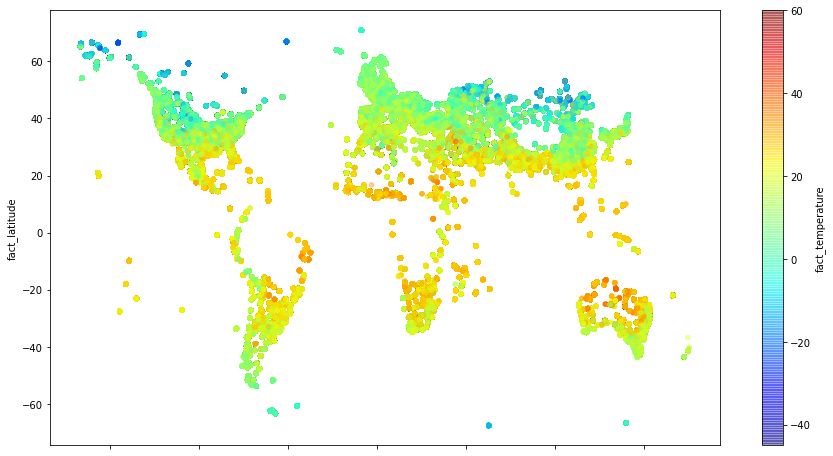

In [4]:
# let's inspect geographical data
# First, look at temperature in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="fact_temperature",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,8))
plt.show()

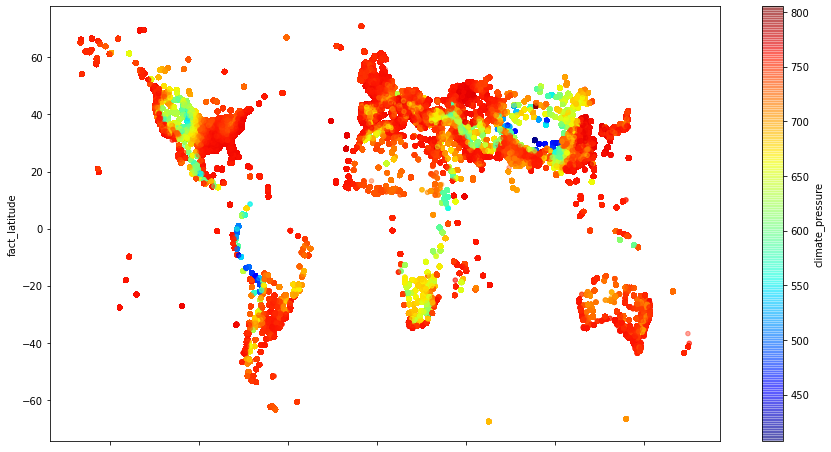

In [5]:
# Now, look at climate pressure in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="climate_pressure",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,8))
plt.show()

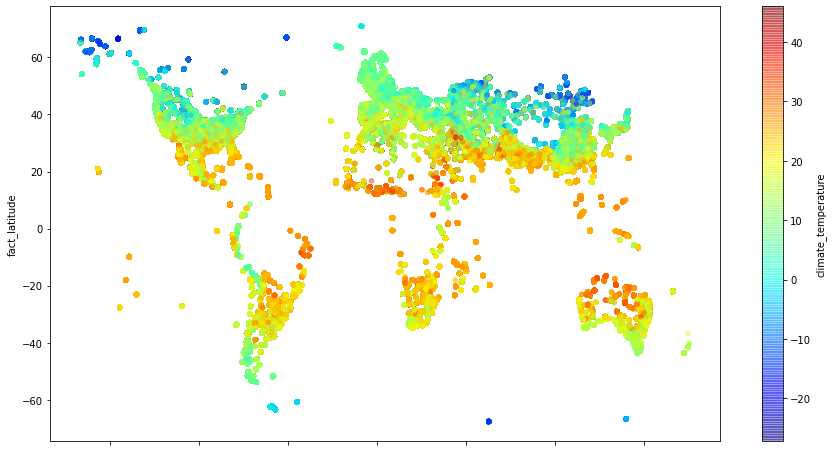

In [6]:
# Look at climate temperature in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="climate_temperature",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,8))
plt.show()

We can see how training data is coming from all around the world, with some exceptions: center and north South America and center of Africa.

# Data cleaning

In [7]:
# check that all features are numerical -> yes, so we don't need encoding
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993574 entries, 0 to 1993573
Columns: 113 entries, index to fact_temperature
dtypes: float64(112), int64(1)
memory usage: 1.7 GB


In [8]:
# get the features with NaN values
count_nan_series = train_df.isna().sum()
nan_cols = count_nan_series[count_nan_series > 0].index.values
nan_cols

array(['cmc_0_0_6_2', 'cmc_0_0_7_1000', 'cmc_0_0_7_2', 'cmc_0_0_7_500',
       'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925', 'cmc_0_1_0_0',
       'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0', 'cmc_0_1_67_0',
       'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_2_2_10', 'cmc_0_2_2_1000',
       'cmc_0_2_2_500', 'cmc_0_2_2_700', 'cmc_0_2_2_850', 'cmc_0_2_2_925',
       'cmc_0_2_3_10', 'cmc_0_2_3_1000', 'cmc_0_2_3_500', 'cmc_0_2_3_700',
       'cmc_0_2_3_850', 'cmc_0_2_3_925', 'cmc_0_3_0_0',
       'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_1000',
       'cmc_0_3_5_500', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925',
       'cmc_0_6_1_0', 'cmc_horizon_h', 'cmc_precipitations',
       'cmc_timedelta_s', 'wrf_t2_next', 'wrf_psfc', 'wrf_rh2',
       'wrf_wind_u', 'wrf_wind_v', 'wrf_rain', 'wrf_snow', 'wrf_graupel',
       'wrf_t2_interpolated', 'wrf_t2_grad', 'cmc_0_1_65_0_grad',
       'cmc_0_1_65_0_next', 'cmc_0_1_66_0_grad', 'cmc_0_1_66_0_next',
       'cmc_0_1_67_0_grad', 'cmc_0_1

In [15]:
# replace NaN with column average
for col in train_df.columns:
    train_df[col].fillna(train_df[col].mean(), inplace=True)
train_df

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
0,0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,...,0.0,0.0,0.000000,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0
1,1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,...,0.0,0.0,0.000000,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0
2,2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,...,0.0,0.0,0.000000,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0
3,3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,...,0.0,0.0,0.000000,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0
4,4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,...,0.0,0.0,0.000000,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993569,1993569,1.543543e+09,32.297199,50.842201,2042.0,-19.050859,2.247143,583.410553,262.803375,21.750,...,0.0,0.0,0.000002,0.0,0.0,-0.899994,-8.449988,0.0,0.0,-2.0
1993570,1993570,1.541552e+09,36.191898,-94.489998,361.0,-6.690413,13.887143,732.386076,281.155746,5.500,...,0.0,0.0,0.000000,0.0,0.0,-1.136932,6.113062,16.0,99.0,12.0
1993571,1993571,1.545372e+09,38.808899,27.833900,76.0,4.815581,4.407143,750.746603,267.692017,6.625,...,0.0,0.0,0.000000,0.0,0.0,1.314484,0.850000,0.0,0.0,-2.0
1993572,1993572,1.544355e+09,18.310000,-15.969722,-7.0,38.690343,19.170714,760.737441,278.651733,19.500,...,0.0,0.0,0.000000,0.0,0.0,1.000000,10.850000,0.0,0.0,28.0


In [ ]:
# remove duplicates
train_df.drop_duplicates(inplace=True, ignore_index=True)
train_df

# Feature selection

In [124]:
def remove_correlated_features(df, threshold):
    corr_matrix = df.corr().abs()
    high_corr_var=np.where(corr_matrix>threshold)
    high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
    # features and how many times they appear in tuples of correlated features
    features_count = pd.Series(sum(np.array(high_corr_var).tolist(), [])).value_counts()
    to_del = set()
    for pair in high_corr_var:
        if features_count[pair[0]] > features_count[pair[1]]:
            to_del.add(pair[0])
        else:
            to_del.add(pair[1])
    return list(to_del)

In [125]:
# drop correlated cmc and gfs features
df_cmc = train_df[train_df.columns.values[train_df.columns.str.contains("cmc") | train_df.columns.str.contains("gfs")]]
features_to_remove = remove_correlated_features(df_cmc, 0.8)
features_to_remove

['cmc_0_1_65_0_next',
 'cmc_0_3_5_925',
 'gfs_pressure',
 'cmc_0_1_0_0',
 'cmc_0_2_3_700',
 'gfs_temperature_90000',
 'gfs_total_clouds_cover_middle',
 'gfs_horizon_h',
 'gfs_temperature_85000',
 'gfs_temperature_70000',
 'cmc_0_2_2_925',
 'gfs_2m_dewpoint',
 'gfs_temperature_30000',
 'gfs_temperature_92500',
 'cmc_0_2_3_10',
 'gfs_total_clouds_cover_low_next',
 'gfs_temperature_40000',
 'cmc_0_1_65_0_grad',
 'gfs_precipitable_water',
 'cmc_0_1_67_0_next',
 'gfs_temperature_45000',
 'cmc_0_3_5_1000',
 'cmc_0_1_66_0_next',
 'cmc_0_1_68_0_next',
 'gfs_temperature_60000',
 'gfs_temperature_10000',
 'gfs_temperature_35000',
 'cmc_0_2_3_1000',
 'cmc_0_3_0_0_next',
 'gfs_2m_dewpoint_next',
 'gfs_temperature_50000',
 'cmc_0_2_2_700',
 'cmc_0_2_2_1000',
 'gfs_temperature_65000',
 'cmc_0_2_2_10',
 'gfs_timedelta_s',
 'gfs_temperature_7000',
 'cmc_0_0_7_2',
 'cmc_0_3_5_850',
 'gfs_temperature_75000',
 'cmc_0_3_5_500',
 'cmc_0_2_3_925',
 'gfs_soil_temperature_available',
 'gfs_temperature_95000',

In [4]:
# check correlation between climate_temperature and target variable (fact_temperature)
train_df["climate_temperature"].corr(train_df["fact_temperature"])

0.8573493386817624

In [9]:
# check correlation between target variable and other features
corr_target = train_df.corrwith(train_df["fact_temperature"])
corr_target

index                              0.001146
fact_time                         -0.443120
fact_latitude                     -0.408776
fact_longitude                     0.140562
topography_bathymetry             -0.151660
                                     ...   
gfs_2m_dewpoint_grad               0.012771
gfs_2m_dewpoint_next               0.734781
gfs_total_clouds_cover_low_grad    0.007315
gfs_total_clouds_cover_low_next   -0.180979
fact_temperature                   1.000000
Length: 113, dtype: float64

In [11]:
# keep highly correlated features only (with target variable)
high_corr_features = corr_target[corr_target > 0.8].index.values
high_corr_features

array(['climate_temperature', 'cmc_0_0_6_2', 'gfs_temperature_80000',
       'gfs_temperature_85000', 'gfs_temperature_90000',
       'gfs_temperature_92500', 'gfs_temperature_95000',
       'gfs_temperature_97500', 'wrf_t2_next', 'wrf_t2_interpolated',
       'fact_temperature'], dtype=object)

In [7]:
# # select manually correlated features
# high_corr_features = ['climate_temperature', 'cmc_0_0_6_2', 'cmc_0_1_0_0',
#                         'cmc_0_3_5_500', 'gfs_2m_dewpoint', 'gfs_temperature_30000',
#                         'gfs_temperature_97500', 'wrf_t2_next', 'wrf_t2_interpolated',
#                         'gfs_2m_dewpoint_next', 'fact_temperature']

In [127]:
features_to_remove

['cmc_0_1_65_0_next',
 'cmc_0_3_5_925',
 'gfs_pressure',
 'cmc_0_1_0_0',
 'cmc_0_2_3_700',
 'gfs_temperature_90000',
 'gfs_total_clouds_cover_middle',
 'gfs_horizon_h',
 'gfs_temperature_85000',
 'gfs_temperature_70000',
 'cmc_0_2_2_925',
 'gfs_2m_dewpoint',
 'gfs_temperature_30000',
 'gfs_temperature_92500',
 'cmc_0_2_3_10',
 'gfs_total_clouds_cover_low_next',
 'gfs_temperature_40000',
 'cmc_0_1_65_0_grad',
 'gfs_precipitable_water',
 'cmc_0_1_67_0_next',
 'gfs_temperature_45000',
 'cmc_0_3_5_1000',
 'cmc_0_1_66_0_next',
 'cmc_0_1_68_0_next',
 'gfs_temperature_60000',
 'gfs_temperature_10000',
 'gfs_temperature_35000',
 'cmc_0_2_3_1000',
 'cmc_0_3_0_0_next',
 'gfs_2m_dewpoint_next',
 'gfs_temperature_50000',
 'cmc_0_2_2_700',
 'cmc_0_2_2_1000',
 'gfs_temperature_65000',
 'cmc_0_2_2_10',
 'gfs_timedelta_s',
 'gfs_temperature_7000',
 'cmc_0_0_7_2',
 'cmc_0_3_5_850',
 'gfs_temperature_75000',
 'cmc_0_3_5_500',
 'cmc_0_2_3_925',
 'gfs_soil_temperature_available',
 'gfs_temperature_95000',

In [129]:
final_train_df = train_df.drop(columns=features_to_remove)
final_train_df

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,wrf_snow,wrf_graupel,wrf_t2_interpolated,wrf_t2_grad,cmc_0_1_66_0_grad,cmc_0_1_67_0_grad,cmc_0_1_68_0_grad,gfs_2m_dewpoint_grad,gfs_total_clouds_cover_low_grad,fact_temperature
0,0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,...,0.000000,0.000000,292.871948,-2.572845,0.0,0.0,0.0,0.058990,0.0,19.0
1,1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,...,0.000000,0.000000,298.968048,-0.216797,0.0,0.0,0.0,0.348022,0.0,25.0
2,2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,...,0.004967,0.001423,286.418102,0.010453,0.0,0.0,0.0,-1.500000,0.0,11.0
3,3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,...,0.000000,0.000000,283.558502,-0.817749,0.0,0.0,0.0,0.299988,0.0,9.0
4,4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,...,0.000000,0.000000,296.265930,-0.174805,0.0,0.0,0.0,-0.500000,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993569,1993569,1.543543e+09,32.297199,50.842201,2042.0,-19.050859,2.247143,583.410553,262.803375,21.750,...,0.004967,0.001423,286.418102,0.010453,0.0,0.0,0.0,-0.899994,0.0,-2.0
1993570,1993570,1.541552e+09,36.191898,-94.489998,361.0,-6.690413,13.887143,732.386076,281.155746,5.500,...,0.000000,0.000000,286.193848,0.578003,0.0,0.0,0.0,-1.136932,16.0,12.0
1993571,1993571,1.545372e+09,38.808899,27.833900,76.0,4.815581,4.407143,750.746603,267.692017,6.625,...,0.000000,0.000000,276.368103,2.540314,0.0,0.0,0.0,1.314484,0.0,-2.0
1993572,1993572,1.544355e+09,18.310000,-15.969722,-7.0,38.690343,19.170714,760.737441,278.651733,19.500,...,0.000000,0.000000,299.917206,2.347687,0.0,0.0,0.0,1.000000,0.0,28.0


# Train

In [142]:
# Get X_train and y_train and normalize
X_train = final_train_df.iloc[:,:-1].to_numpy()
y_train = final_train_df['fact_temperature'].to_numpy()
Xmean, Xstd, ymean, ystd = X_train.mean(0), X_train.std(0), y_train.mean(), y_train.std()
X_train = (X_train - Xmean) / (Xstd + 0.001)
y_train = (y_train - ymean) / ystd

In [44]:
# grid search cv

param_grid = {
            "alpha": [0.001, 0.01, 1]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, 
                  scoring="neg_root_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 1]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [ ]:
# # grid search cv

# param_grid = {
#             "n_estimators": [500],
#             "max_depth": [None],
#             "max_features": ["sqrt"],
#             "criterion": ["mse","gini","entropy"],
#             "random_state": [42]
#             }
# gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, scoring="neg_root_mean_squared_error",
#                   verbose=True, n_jobs=-1,cv=5)
# gs.fit(X,y)

In [47]:
print(f"Best set of parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

Best set of parameters: {'alpha': 0.001}
Best score: -0.2950197040044452


In [ ]:
# Now train with full train dataset and best parameters
model = RandomForestRegressor(n_estimators=500, max_depth=None, max_features="sqrt", criterion="mse", random_state=42)
model.fit(X_train, y_train)

c:\users\andrea\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


In [143]:
# Now train with full train dataset and best parameters
model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

Lasso(alpha=0.001)

In [144]:
def compute_rmse(y, ypred, ystd=1.):
    return np.mean((y - ypred)**2)**0.5 * ystd

model.fit(X_train[:1300000], y_train[:1300000])
y_val = y_train[1300000:]
y_val_pred = model.predict(X_train[1300000:])
compute_rmse(y_val, y_val_pred)

0.2554357338791862

# Test

In [145]:
test_df = pd.read_csv("data/test_feat.csv", low_memory=True)
final_test_df = test_df.drop(columns=features_to_remove)
# replace NaN with column average
for col in final_test_df.columns:
    final_test_df[col].fillna(final_test_df[col].mean(), inplace=True)
final_test_df

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,wrf_rain,wrf_snow,wrf_graupel,wrf_t2_interpolated,wrf_t2_grad,cmc_0_1_66_0_grad,cmc_0_1_67_0_grad,cmc_0_1_68_0_grad,gfs_2m_dewpoint_grad,gfs_total_clouds_cover_low_grad
0,1993574,1.547967e+09,33.466499,-82.039398,129.0,-74.604821,7.053571,756.861547,286.466949,0.875,...,0.456730,0.000000,0.0,288.065277,-0.143005,0.0000,0.0,0.0,-3.000000,-48.0
1,1993575,1.550765e+09,-3.552530,-80.381401,26.0,68.688172,24.221429,754.893806,296.029541,2.625,...,0.000000,0.000000,0.0,301.489624,0.770447,0.0000,0.0,0.0,0.291351,2.0
2,1993576,1.537093e+09,59.878899,-1.295560,2.0,26.380551,11.789286,756.023981,284.402039,1.125,...,0.143329,0.000000,0.0,285.445374,0.168579,0.0000,0.0,0.0,-1.100006,8.0
3,1993577,1.548846e+09,39.048801,-84.667801,263.0,-29.799833,0.808571,743.716901,252.938766,7.125,...,0.019374,0.019374,0.0,254.881241,-0.555634,0.1661,0.0,0.0,-0.795135,26.0
4,1993578,1.547161e+09,32.566700,-117.116997,6.0,27.294687,14.082143,762.318629,284.741882,3.125,...,0.000000,0.000000,0.0,288.134308,0.065277,0.0000,0.0,0.0,0.702820,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552169,2571808,1.547370e+09,17.161111,99.861667,57.0,23.957253,27.865000,752.503439,293.529724,12.125,...,0.001034,0.000000,0.0,307.483032,-0.450256,0.0000,0.0,0.0,-0.223541,7.0
552170,2571809,1.548893e+09,4.000000,9.733333,7.0,-73.836607,26.476429,762.391340,296.549973,1.750,...,1.212770,0.000000,0.0,299.395386,-0.418610,0.0000,0.0,0.0,-0.342743,0.0
552171,2571810,1.536496e+09,8.482120,76.920097,16.0,13.476526,26.450763,754.343654,296.088379,4.625,...,0.000000,0.000000,0.0,300.097137,0.048309,0.0000,0.0,0.0,0.399994,0.0
552172,2571811,1.544098e+09,-0.633333,127.500000,36.0,-33.814418,26.817143,745.765796,296.621796,5.625,...,0.000000,0.000000,0.0,298.390564,0.178223,0.0000,0.0,0.0,0.000000,0.0


In [147]:
# Get X_test and normalize
X_test = final_test_df.to_numpy()
X_test = (X_test - Xmean) / (Xstd + 0.001)

In [151]:
y_pred = model.predict(X_test) * ystd + ymean
y_pred.min()

-36.47556201148241

In [149]:
submission_df = pd.DataFrame(data={'index': test_df['index'].values,
                                   'fact_temperature': y_pred.squeeze()})

# Save the predictions into a csv file
# Notice that this file should be saved under the directory `/kaggle/working` 
# so that you can download it later
submission_df.to_csv("submission.csv", index=False)

# Old stuff

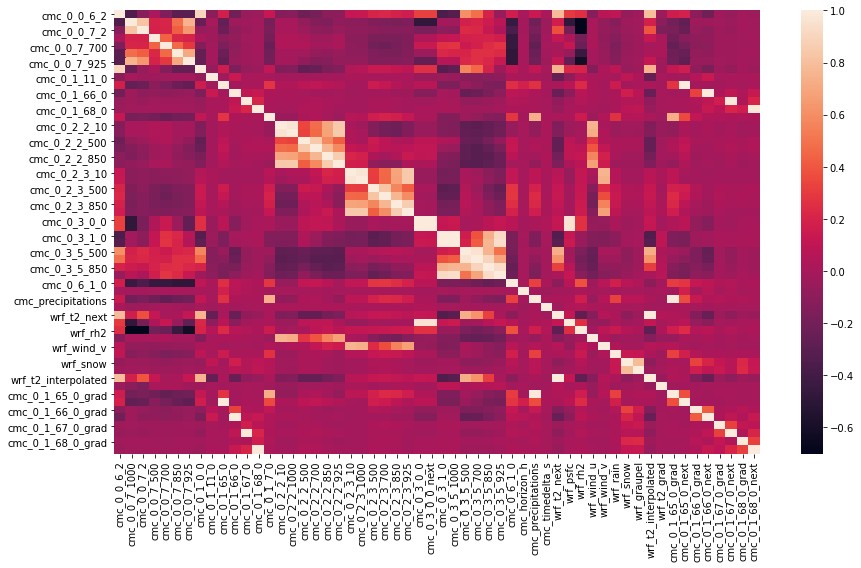

In [40]:
plt.figure(figsize = (13,8))
nan_corr_df = train_df[nan_cols].corr() 
sns.heatmap(nan_corr_df)
plt.tight_layout()
plt.show()

In [61]:
nan_corr_mat = nan_corr_df.corr().abs()
# select upper triangle of corr matrix
upper = nan_corr_mat.where(np.triu(np.ones(nan_corr_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))
to_drop

23


['cmc_0_0_7_925',
 'cmc_0_1_0_0',
 'cmc_0_2_2_1000',
 'cmc_0_2_2_700',
 'cmc_0_2_2_925',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_700',
 'cmc_0_2_3_925',
 'cmc_0_3_0_0_next',
 'cmc_0_3_5_1000',
 'cmc_0_3_5_700',
 'cmc_precipitations',
 'wrf_psfc',
 'wrf_rh2',
 'wrf_wind_u',
 'wrf_wind_v',
 'wrf_graupel',
 'wrf_t2_interpolated',
 'cmc_0_1_65_0_grad',
 'cmc_0_1_65_0_next',
 'cmc_0_1_66_0_next',
 'cmc_0_1_67_0_next',
 'cmc_0_1_68_0_next']

In [60]:
upper['cmc_0_0_7_925']

cmc_0_0_6_2            0.363319
cmc_0_0_7_1000         0.959149
cmc_0_0_7_2            0.914098
cmc_0_0_7_500          0.601984
cmc_0_0_7_700          0.657595
cmc_0_0_7_850          0.927795
cmc_0_0_7_925               NaN
cmc_0_1_0_0                 NaN
cmc_0_1_11_0                NaN
cmc_0_1_65_0                NaN
cmc_0_1_66_0                NaN
cmc_0_1_67_0                NaN
cmc_0_1_68_0                NaN
cmc_0_1_7_0                 NaN
cmc_0_2_2_10                NaN
cmc_0_2_2_1000              NaN
cmc_0_2_2_500               NaN
cmc_0_2_2_700               NaN
cmc_0_2_2_850               NaN
cmc_0_2_2_925               NaN
cmc_0_2_3_10                NaN
cmc_0_2_3_1000              NaN
cmc_0_2_3_500               NaN
cmc_0_2_3_700               NaN
cmc_0_2_3_850               NaN
cmc_0_2_3_925               NaN
cmc_0_3_0_0                 NaN
cmc_0_3_0_0_next            NaN
cmc_0_3_1_0                 NaN
cmc_0_3_5_1000              NaN
cmc_0_3_5_500               NaN
cmc_0_3_

In [63]:
train_df.columns.values

array(['index', 'fact_time', 'fact_latitude', 'fact_longitude',
       'topography_bathymetry', 'sun_elevation', 'climate_temperature',
       'climate_pressure', 'cmc_0_0_6_2', 'cmc_0_0_7_1000', 'cmc_0_0_7_2',
       'cmc_0_0_7_500', 'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925',
       'cmc_0_1_0_0', 'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0',
       'cmc_0_1_67_0', 'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_2_2_10',
       'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
       'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
       'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925',
       'cmc_0_3_0_0', 'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_1000',
       'cmc_0_3_5_500', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925',
       'cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h',
       'cmc_precipitations', 'cmc_timedelta_s', 'gfs_2m_dewpoint',
       'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness',
       'gfs_clouds_sea', 'gfs_ho

In [68]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper
# to drop: cmc_0_2_2_1000, cmc_0_2_2_925, cmc_0_2_3_1000, cmc_0_2_3_925

,cmc_0_2_2_10,cmc_0_2_2_1000,cmc_0_2_2_500,cmc_0_2_2_700,cmc_0_2_2_850,cmc_0_2_2_925,cmc_0_2_3_10,cmc_0_2_3_1000,cmc_0_2_3_500,cmc_0_2_3_700,cmc_0_2_3_850,cmc_0_2_3_925
cmc_0_2_2_10,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_1000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_500,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_700,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_850,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_925,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_3_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0
cmc_0_2_3_1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
cmc_0_2_3_500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
cmc_0_2_3_700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [ ]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper

In [ ]:
final_train_df = train_df.copy()
to_keep = ['fact_latitude','fact_longitude','topography_bathymery','sun_elevation', 'climate_temperature', 'climate_pressure',
         'cmc_0_0_6_2', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_1_0_0']

In [92]:
train_df_samples['fact_temperature'].to_numpy()

array([ 4., 13.,  7., ..., 19., 10., 25.])

In [94]:
train_df_samples = train_df.sample(int(0.4 * len(train_df)))

In [105]:
y = train_df_samples['fact_temperature'].to_numpy()
X = train_df_samples.fillna(0).iloc[:,:-1].to_numpy()

In [ ]:
# grid search cv

param_grid = {
            "alpha": [1]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring="neg_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
